## Hands Signal Language - PTBR (Libras) - Verification (VGGNET) ##

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

In [2]:
import sys
sys.path.append("C:/Users/Mafeus/Desktop/Git_Repos/OpenCV")
sys.path.append('C:/Users/Mafeus/Desktop/Git_Repos/OpenCV/Gesture Recognition/modules')
import OpCV_Utils
import extractor_POSITION as Position
import extractor_PROXIMITY as Proximity
import extractor_HEIGHT as Height 
import alphabet

### Basic Functions: ####

In [3]:
def hand_keypoints_processing(image, model):
    
    start = time.time()
    
    h_input = 236
    w_input = int((((image.shape[1]/image.shape[0]) * h_input) * 8) // 8)
    
    # Transform img to compatible blob format:
    blob_input = cv2.dnn.blobFromImage(image = image, scalefactor = 1.0/255, size = (w_input, h_input), 
                                       mean = (0,0,0), swapRB = False, crop = False)
    # Process image:
    model.setInput(blob_input)
    output = model.forward()
    
    end = time.time()
    
    print('Processing Time:', (end-start), 's')
    
    return output

In [4]:
def paint_numbers(image, output, number_of_points, point_color, line_color, limit=0.1):
        
    h_input = image.shape[0]
    w_input = image.shape[1]
    
    points = []
    
    height = output.shape[2]
    width = output.shape[3]

    for i in range(number_of_points):
        confidence_map = output[0, i, :, :]
        _, confidence, _, p_coord = cv2.minMaxLoc(confidence_map)

        x = (w_input*p_coord[0])/width
        y = (h_input*p_coord[1])/height

        if (confidence > limit):
            cv2.circle(image, (int(x), int(y)), 8, point_color, thickness = -1, lineType = cv2.FILLED)
            cv2.putText(image, '{}'.format(i), (int(x)+2, int(y)+2), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                        (0, 0, 0), 3, lineType = cv2.LINE_AA)

            points.append((int(x), int(y)))

    return image, points

In [5]:
def paint_skeleton(image, points, keypoints_pairs, point_color, line_color, limit=0.1):
     
    h_input = image.shape[0]
    w_input = image.shape[1]
    
    point_color = (255, 128, 0)
    line_color = (7, 62, 248)
    
    size = cv2.resize(image, (w_input, h_input))
    soft_map = cv2.GaussianBlur(size, (3,3), 0, 0)
    mask_map = np.uint8(soft_map > limit)
    
    for pair in keypoints_pairs:
        a = pair[0]
        b = pair[1]

        if (points[a] and points[b]):
            cv2.line(image, points[a], points[b], line_color, 3)
            cv2.circle(image, points[a], 8, point_color, thickness = -1, lineType = cv2.LINE_AA)

            cv2.line(mask_map, points[a], points[b], line_color, 3)
            cv2.circle(mask_map, points[a], 8, point_color, thickness = -1, lineType = cv2.LINE_AA)

    return mask_map

In [6]:
def check_hand_signal(image, points, letters):
    
    Position.posicoes = []
    # Dedo polegar
    Position.verificar_posicao_DEDOS(points[1:5], 'polegar', Height.verificar_altura_MAO(points))
    # Dedo indicador
    Position.verificar_posicao_DEDOS(points[5:9], 'indicador', Height.verificar_altura_MAO(points))
    # Dedo médio
    Position.verificar_posicao_DEDOS(points[9:13], 'medio', Height.verificar_altura_MAO(points))
    # Dedo anelar
    Position.verificar_posicao_DEDOS(points[13:17], 'anelar', Height.verificar_altura_MAO(points))
    # Dedo mínimo
    Position.verificar_posicao_DEDOS(points[17:21], 'minimo', Height.verificar_altura_MAO(points))

    p = Proximity.verificar_proximidade_DEDOS(points)
    
    for i, a in enumerate(alphabet.letras):
        if Proximity.verificar_proximidade_DEDOS(points) == alphabet.letras[i]:
            print('Detected')
            image = cv2.putText(image, ' ' + letters[i], (5,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 5, lineType=cv2.LINE_AA)
    
    return image

### Config Model and test with image: ###

In [7]:
# Coco config files:
coco_proto_file_path = 'C:/Users/Mafeus/Desktop/CURSO reconhecimento gestos/pose/pose/hand/pose_deploy.prototxt'
coco_weights_file_path = 'C:/Users/Mafeus/Desktop/CURSO reconhecimento gestos/pose/pose/hand/pose_iter_102000.caffemodel'

# Config Coco Caffe Model:
coco_model = cv2.dnn.readNetFromCaffe(coco_proto_file_path, coco_weights_file_path)
coco_number_of_points = 22
coco_hand_keypoints_pairs = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 5], [5, 6], [6, 7], [7, 8], 
                            [0, 9], [9, 10], [10, 11], [11, 12], [0, 13], [13, 14], [14, 15],
                            [15, 16], [0, 17], [17, 18], [18, 19], [19, 20]]

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q',
          'R', 'S', 'T', 'U', 'V', 'W']

### Testing in Video ###

In [8]:
# Load Video:
video = 'C:/Users/Mafeus/Desktop/CURSO reconhecimento gestos/imagens/imagens/hand/Libras/libras.mp4'
cap = cv2.VideoCapture(video)
success, frame = cap.read()
video_fps = cap.get(cv2.CAP_PROP_FPS)
point_color = (255, 128, 0)
line_color = (7, 62, 248)

recorded_video = cv2.VideoWriter("./result_hand.avi", cv2.VideoWriter_fourcc(*'XVID'), 10, (frame.shape[1], frame.shape[0]))
    
while True:
    
    start = time.time()
    
    success, frame = cap.read()
    
    if not success:
        print('Server OFF')
        break
    
    # Keyboard Controls:
    
    key = cv2.waitKey(1) or 0xff   
        
    if key == ord('k'):
        break
    
    #######################################
    
    output = hand_keypoints_processing(frame.copy(), coco_model)
    
    img_with_numbers, det_points = paint_numbers(frame.copy(), output, coco_number_of_points, point_color, line_color, limit=0.1)
    
    skeleton_img = paint_skeleton(img_with_numbers, det_points, coco_hand_keypoints_pairs, point_color, line_color, limit=0.1)
    
    #######################################
    
    end = time.time()

    frame_time = (end - start) + 0.0001
    #fps = np.floor(1/frame_time)
    fps = 1/frame_time
        
    if (fps > video_fps):
        time.sleep(1/video_fps)
        fps = video_fps
    
    final_frame = OpCV_Utils.stackImgs([[frame, img_with_numbers], [skeleton_img]], sep_lines=True, scale=0.9)
    
    final_frame = check_hand_signal(final_frame, det_points, letters)
    
    cv2.putText(final_frame, "FPS: {:.2f}".format(fps), (20,200), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    cv2.imshow("Output", final_frame)
    
    recorded_video.write(final_frame)
    
cv2.destroyAllWindows()
cap.release()
recorded_video.release()

Processing Time: 1.7614233493804932 s
Detected
Processing Time: 1.8221464157104492 s
Detected
Processing Time: 1.881939172744751 s
Detected
Processing Time: 1.7661786079406738 s
Detected
Processing Time: 1.734982967376709 s
Detected
Processing Time: 1.659341812133789 s
Detected


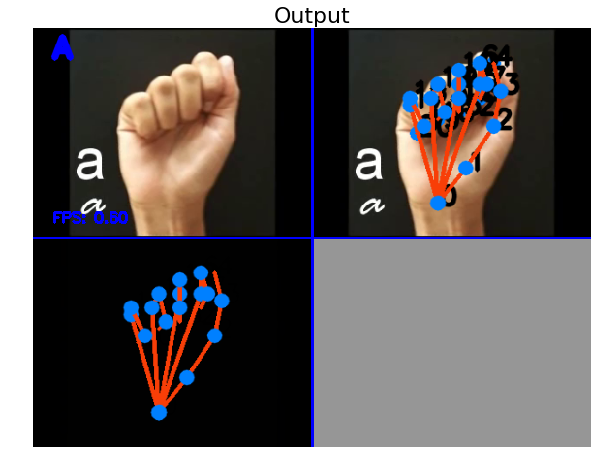

In [9]:
OpCV_Utils.show_single_img_plt(cv2.cvtColor(final_frame, cv2.COLOR_BGR2RGB), 'Output', fig_size = (10,10))